# Setup

## Create API Key

Go create an API key for using Gemini (FREE!) here, https://aistudio.google.com/app/apikey. Make sure the plan says "Free of charge"

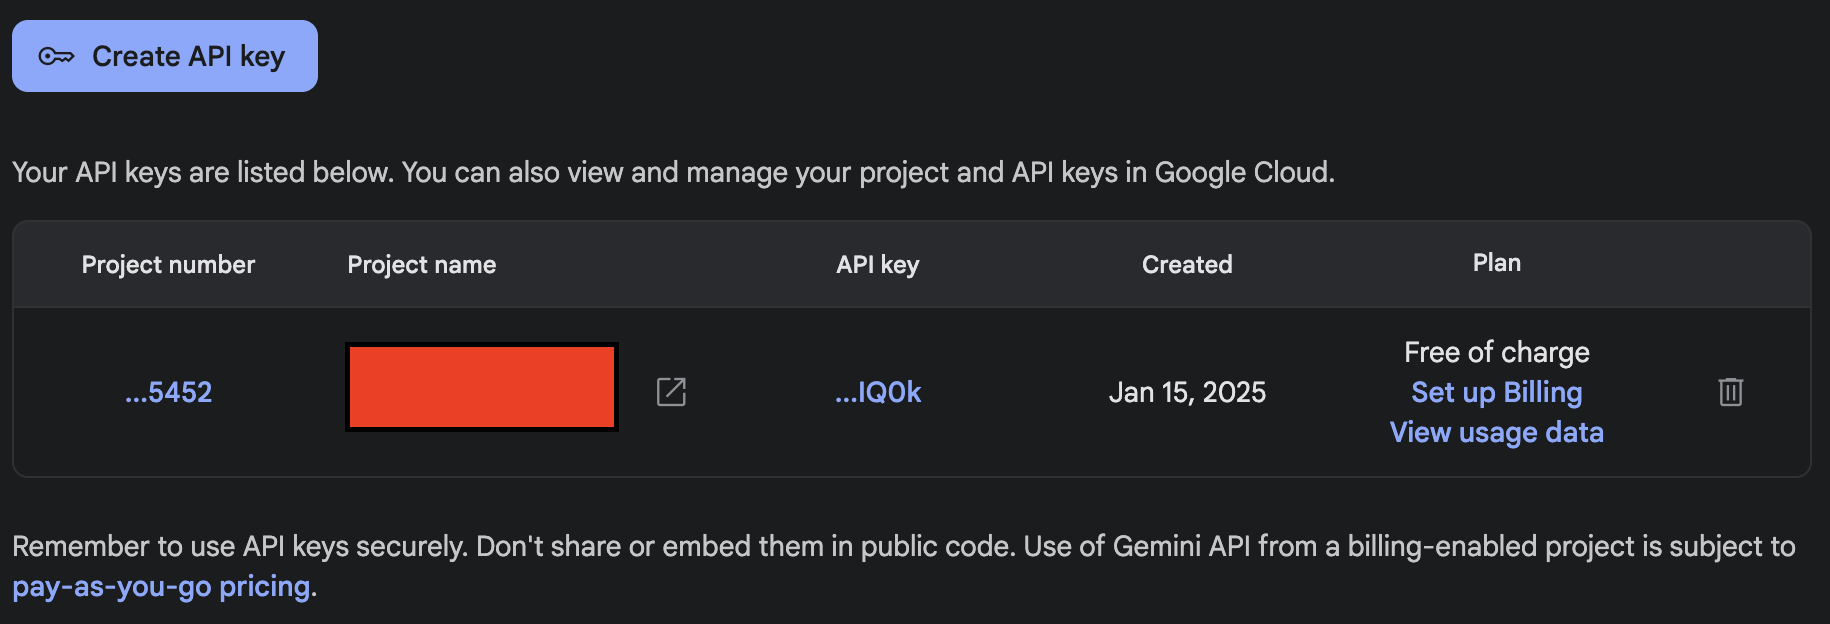

## Add API to notebook

After creating your API key, add it to your colab notebook.

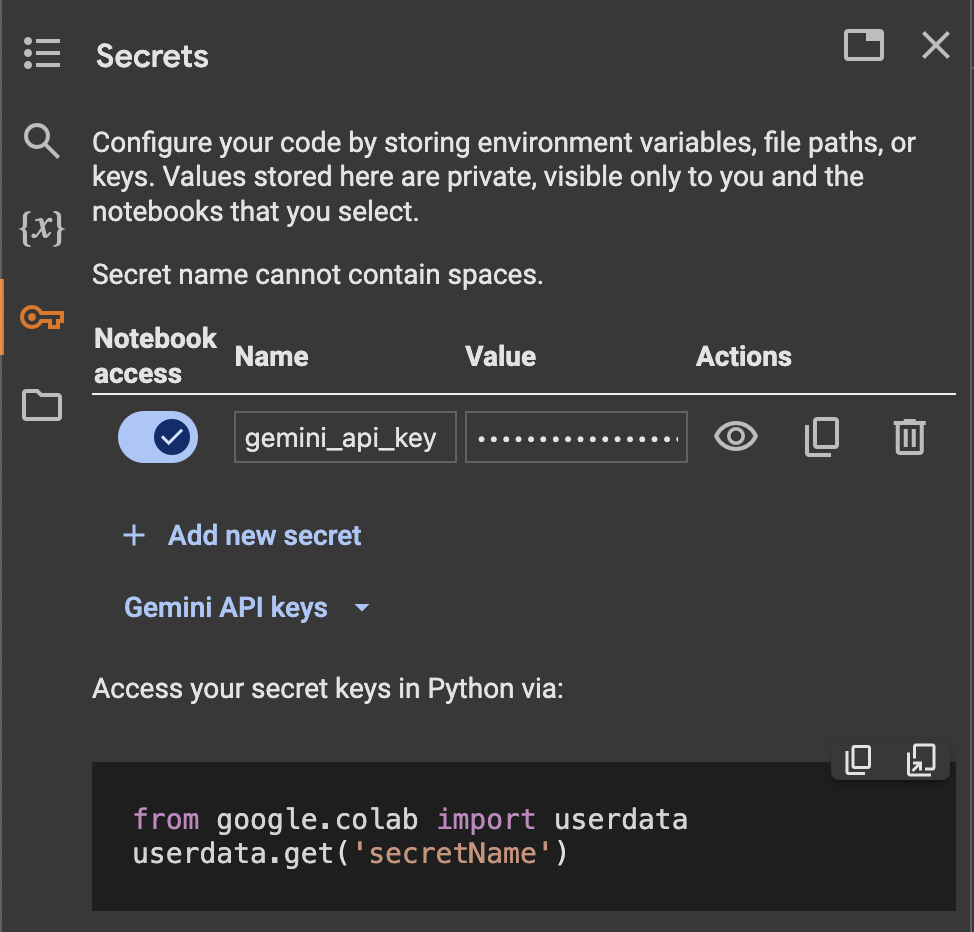

In [ ]:
!pip install datasets

# Code

## FYI: Free Tier Rate Limits


*   For the `gemini-2.0-flash-lite`, you are allowed 30 requests/min and 1,500 requests/day
*   For `gemini-2.0-flash-001` and `gemini-1.5-flash`, it is 15 requests per minute and 1,500RPD.



## Utility code

In [ ]:
from collections import Counter

def get_judge_name(judge):
    if isinstance(judge, list) and judge[0] == "gpt-4" and judge[1].startswith("pair"):
        return "gpt4-pair"
    if judge.startswith("expert"):
        return "human"
    if judge.startswith("author"):
        return "author"
    return judge


def revert(vote):
    if vote == "model_a":
        return "model_b"
    elif vote == "model_b":
        return "model_a"
    return vote

def get_mt_bench_votes_data(raw_votes):
    data = [{}, {}]

    for judge_votes in raw_votes:
        for vote in judge_votes:
            turn = vote["turn"] - 1
            if vote["model_a"] < vote["model_b"]:
                key = (vote["question_id"], vote["model_a"], vote["model_b"])
                winner = vote["winner"]
            else:
                key = (vote["question_id"], vote["model_b"], vote["model_a"])
                winner = revert(vote["winner"])
            judge = get_judge_name(vote["judge"])
            if key not in data[turn]:
                data[turn][key] = {}
            if judge not in data[turn][key]:
                data[turn][key][judge] = []
            data[turn][key][judge].append(winner)

    return data

def convertvote(vote):
    if "tie" in vote:
        return "tie"
    return vote


def equalvote(vote1, vote2):
    if "tie" in vote1 and "tie" in vote2:
        return True
    return vote1 == vote2

def most_common_last_tiebreak(lst):
    counts = Counter(lst)
    max_count = max(counts.values())

    candidates = [x for x in lst if counts[x] == max_count]

    return candidates[-1]

def get_mt_bench_agreement(data, judge1, judge2, ban):
    if judge1.startswith("gemini") and judge2 == "human":
        stats = [0, 0]
        for votes in data.values():
            if judge1 not in votes or judge2 not in votes: continue

            if len(votes[judge1]) > 1:
                votes[judge1] = [most_common_last_tiebreak(votes[judge1])]

            assert len(votes[judge1]) == 1
            if convertvote(votes[judge1][0]) in ban: continue
            for v in votes[judge2]:
                if convertvote(v) in ban: continue
                stats[1] += 1
                stats[0] += equalvote(votes[judge1][0], v)
        return stats[0], stats[1]

In [ ]:
from google.colab import userdata
api_key = userdata.get('gemini_api_key')

In [ ]:
import google.generativeai as genai
from tqdm import tqdm
import datasets

genai.configure(api_key=api_key)
generation_config = genai.GenerationConfig(
        temperature=0,
)
model = genai.GenerativeModel("gemini-2.0-flash-001", generation_config=generation_config)

In [ ]:
from google.api_core import retry

# Catch transient Gemini errors.
def is_retryable(e) -> bool:
    if retry.if_transient_error(e):
        # Good practice, but probably won't fire with the google-genai SDK
        return True
    elif (isinstance(e, genai.errors.ClientError) and e.code == 429):
        # Catch 429 quota exceeded errors
        return True
    elif (isinstance(e, genai.errors.ServerError) and e.code == 503):
        # Catch 503 model overloaded errors
        return True
    else:
        return False

@retry.Retry(predicate=is_retryable)
def generate_content_with_rate_limit(prompt):
  return model.generate_content(prompt).text

# LLM-as-a-Judge

Objective:
In this assignment, you will use a Large Language Model (LLM) as a judge to evaluate AI-generated responses from the [MT-Bench](https://huggingface.co/datasets/lmsys/mt_bench_human_judgments) dataset.


In [ ]:
from datasets import load_dataset

ds = load_dataset("lmsys/mt_bench_human_judgments")

We will be using a subset of 100 examples.

In [ ]:
human_subset = ds["human"].take(100)
human_subset.to_json("human_judgements.json")

This is an example of the data we will be evaluating.

This dataset contains evaluations of AI-generated conversations, where a judge model selects the better response between two AI assistants based on multiple criteria. Each data entry includes:

*   `question_id`: Unique identifier for the prompt.
*   `model_a / model_b`: The AI models generating responses.
*   `winner`: The model chosen as the better performer.
*   `judge`: The entity making the decision (e.g., a human annotator or another LLM). In this case, it is one of the dataset author.
*   `conversation_a / conversation_b`: The full dialogue history for each model, including user prompts and assistant responses.
*   `turn`: Number of interaction rounds in the conversation.





In [ ]:
human_subset[0]

## TODO 1: Design a prompt for Pairwise Comparison

Create a prompt that enables an LLM to act as a binary judge, selecting the better response between two AI-generated outputs from the MT-Bench dataset.

In [ ]:
judge_prompt = ""

You may also need to write a function to parse the model's responses.

In [ ]:
def parse_response(response: str) -> str:
  """
    parses a model's response to return either `model_a`, `model_b`, or `tie`.
  """
  pass

##TODO 1.1: Perform the comparison and report the result
Now prompt the LLM of your choice with your prompt and obtain the judgement on which assistant does a better job.

In [ ]:
all_votes = []
for one_data in tqdm(human_subset):
  ### Fill code here

  ### End fill code

  data = one_data.copy()
  data["judge"] = "gemini-2.0-flash"
  data["winner"] = ... #your variable needs to be either `model_a`, `model_b`, or `tie`
  all_votes.append(data)

run this to get your score

In [ ]:
datasets.Dataset.from_list(all_votes).to_json("my_result.json")

import json
votes = []
for filename in ["my_result.json", "human_judgements.json"]:
    data = []
    for line in open(filename, "r"):
        data.append(json.loads(line))
    votes.append(data)
data = get_mt_bench_votes_data(votes)

judges = ["gemini-2.0-flash", "human"]
agree, total = get_mt_bench_agreement(data[0], judges[0], judges[1], ban=[])
print(f"turn 1 with tie. #total: {total}, #agree: {agree}, ratio: {agree/total:.2f}")
agree, total = get_mt_bench_agreement(data[0], judges[0], judges[1], ban=["tie"])
print(f"turn 1 without tie. #total: {total}, #agree: {agree}, ratio: {agree/total:.2f}")
agree, total = get_mt_bench_agreement(data[1], judges[0], judges[1], ban=[])
print(f"turn 2 with tie. #total: {total}, #agree: {agree}, ratio: {agree/total:.2f}")
agree, total = get_mt_bench_agreement(data[1], judges[0], judges[1], ban=["tie"])
print(f"turn 2 without tie. #total: {total}, #agree: {agree}, ratio: {agree/total:.2f}")

## MCV Q1: Capture your result and upload it to MCV. You should get more than 50% agreement ratio on turn 1 with tie.

## TODO 2: Design a prompt for Pairwise Comparison based on the CHIE Framework

ref: https://aclanthology.org/2024.genbench-1.10.pdf

Create a prompt that enables an LLM to grade each response based on rubrics similar to the CHIE framework. Note that the framework was designed for reading comprehension, therefore, you will have to design your own prompt.


In [ ]:
judge_prompt = ""

In [ ]:
all_votes = []
for one_data in tqdm(human_subset):
  ### Fill code here

  # ### End fill code

  data = one_data.copy()
  data["judge"] = "gemini-2.0-flash"
  data["winner"] = ... #your variable needs to be either `model_a`, `model_b`, or `tie`
  all_votes.append(data)
  # break

run this to get your score

In [ ]:
datasets.Dataset.from_list(all_votes).to_json("my_result.json")
votes = []
for filename in ["my_result.json", "human_judgements.json"]:
    data = []
    for line in open(filename, "r"):
        data.append(json.loads(line))
    votes.append(data)
data = get_mt_bench_votes_data(votes)

judges = ["gemini-2.0-flash", "human"]
agree, total = get_mt_bench_agreement(data[0], judges[0], judges[1], ban=[])
print(f"turn 1 with tie. #total: {total}, #agree: {agree}, ratio: {agree/total:.2f}")
agree, total = get_mt_bench_agreement(data[0], judges[0], judges[1], ban=["tie"])
print(f"turn 1 without tie. #total: {total}, #agree: {agree}, ratio: {agree/total:.2f}")
agree, total = get_mt_bench_agreement(data[1], judges[0], judges[1], ban=[])
print(f"turn 2 with tie. #total: {total}, #agree: {agree}, ratio: {agree/total:.2f}")
agree, total = get_mt_bench_agreement(data[1], judges[0], judges[1], ban=["tie"])
print(f"turn 2 without tie. #total: {total}, #agree: {agree}, ratio: {agree/total:.2f}")

## MCV Q2: Capture your result and upload it to MCV. You should get more than 33% agreement ratio on turn 1 with tie.

## TODO 3: Discussion

Which method of prompting performed better? Why do you think the results are the way they are?

Hint: consider multiple dimensions such as:
1. the judge model's intelligence you used in this exercise vs those typically used in research papers.
2. the task you are evaluating, which prompting style is more suitable?
3. the difficulty of user prompts (e.g. how would a smaller model perform compared to the smartest model on prompts like "write a short paragraph about dogs" compared to hard prompts like trick questions etc.)

## MCV Q3: please also paste your answer into MCV as well.